### Configuración

In [35]:
import sys, os
ON_COLAB = 'google.colab' in sys.modules

if ON_COLAB:
    GIT_ROOT = 'https://github.com/blueprints-for-text-analytics-python/blueprints-text/raw/master'
    os.system(f'wget {GIT_ROOT}/ch04/setup.py')

%run -i setup.py

You are working on a local system.
Files will be searched relative to "..".


In [36]:
import pandas as pd

%run "settings.py"

%reload_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'png'

# to print output of all statements and not just the last
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# otherwise text between $ signs will be interpreted as formula and printed in italic
pd.set_option('display.html.use_mathjax', False)

# path to import blueprints packages
# sys.path.append(BASE_DIR + '/packages')

In [37]:
import pandas as pd

file = "datos/lima-andina-articulos-con-texto.csv"
df = pd.read_csv(file)
df.sample(2)

,Id,Sección de El Comercio,El Comercio Section,Página,Number,Fecha,(PDF),Edición,Palabras Clave,Source Id,Id_Asoc,Asociación,Titulo Original,Texto,Unnamed: 14,Seccion de El Comercio
322,323,Sociedades é Instituciones,4,5,36563,1917/6/2,33,Tarde,"Citación, asamblea general",1.00,22,Centro Chupaca,CENTRO CHUPACA,"CENTRO CHUPACA - Los socios de esta institución están citados a sesión para hoy sábado 2 de junio a las 8 p.m. en su local, calle Chacarilla número 459.",NaN,NaN
5300,5301,Sociedades é Instituciones,4,12,45343,1930/11/27,49,Tarde,"Junta general, citación",1.00,173,Centro Social Progresista Hijos de Julcamarca,"=TRIM(LEFT(N5302,FIND("" -"",N5302)))","CENTRO JULCAMARCA - Cita a sus asociados a la sesión de junta extraordinaria que se realizará hoy jueves 27 a las 8 p.m. en la calle de Quilca número 250, interior 27 altos.",NaN,NaN


In [38]:
df.to_pickle("lima-andina-articulos.pkl")

In [39]:
df['Texto'].fillna('unkown', inplace=True)

In [40]:
df['Año'] = pd.DatetimeIndex(df['Fecha']).year

In [41]:
import spacy
nlp = spacy.load("es_core_news_sm")
text = "A mi mejor amigo Rául Pérez le encantan los juegos de aventura elegantes."
doc = nlp(text)

In [42]:
def display_nlp(doc, include_punct=False):
    """Generate data frame for visualization of spaCy tokens."""
    rows = []
    for i, t in enumerate(doc):
        if not t.is_punct or include_punct:
            row = {'token': i,  'text': t.text, 'lemma_': t.lemma_, 
                   'is_stop': t.is_stop, 'is_alpha': t.is_alpha,
                   'pos_': t.pos_, 'dep_': t.dep_, 
                   'ent_type_': t.ent_type_, 'ent_iob_': t.ent_iob_}
            rows.append(row)
    
    df = pd.DataFrame(rows).set_index('token')
    df.index.name = None
    return df

In [43]:
display_nlp(doc)

,text,lemma_,is_stop,is_alpha,pos_,dep_,ent_type_,ent_iob_
0,A,a,True,True,ADP,case,,O
1,mi,mi,True,True,DET,det,,O
2,mejor,mejor,True,True,ADJ,amod,,O
3,amigo,amigo,False,True,NOUN,obj,,O
4,Rául,Rául,False,True,PROPN,appos,PER,B
5,Pérez,Pérez,False,True,PROPN,flat,PER,I
6,le,él,True,True,PRON,obj,,O
7,encantan,encantar,False,True,VERB,ROOT,,O
8,los,el,True,True,DET,det,,O
9,juegos,juego,False,True,NOUN,nsubj,,O


In [44]:
nlp = spacy.load('es_core_news_sm') ###
text = "Estimado Rául, nos tenemos que sentar y conversar. Saludos, Pedro."
doc = nlp(text)

non_stop = [t for t in doc if not t.is_stop and not t.is_punct]
print(non_stop)

[Estimado, Rául, sentar, conversar, Saludos, Pedro]


In [45]:
import textacy

tokens = textacy.extract.words(doc, 
            filter_stops = True,           # default True, no stopwords
            filter_punct = True,           # default True, no punctuation
            filter_nums = True,            # default False, no numbers
            include_pos = ['ADJ', 'NOUN'], # default None = include all
            exclude_pos = None,            # default None = exclude none
            min_freq = 1)                  # minimum frequency of words

print(*[t for t in tokens], sep='|')

Saludos


In [46]:
def extract_lemmas(doc, **kwargs):
    return [t.lemma_ for t in textacy.extract.words(doc, **kwargs)]

lemmas = extract_lemmas(doc, include_pos=['ADJ', 'NOUN'])
print(*lemmas, sep='|')

saludo


### Extraer frases nominales

In [47]:
text = "A mi mejor amigo Rául Pérez le encantan los elegantes juegos de aventura."
doc = nlp(text)

patterns = ["POS:ADJ POS:NOUN:+"]

if textacy.__version__ < '0.11':
    # as in book
    spans = textacy.extract.matches(doc, patterns=patterns)
else:
    # new textacy version
    spans = textacy.extract.matches.token_matches(doc, patterns=patterns)
    
print(*[s.lemma_ for s in spans], sep='|')

mejor amigo


In [48]:
print(*doc.noun_chunks, sep='|')

mi mejor amigo|Rául Pérez|le|los elegantes|juegos|aventura


In [49]:
def extract_noun_phrases(doc, preceding_pos=['NOUN'], sep='_'):
    patterns = []
    for pos in preceding_pos:
        patterns.append(f"POS:{pos} POS:NOUN:+")

    if textacy.__version__ < '0.11':
        # as in book
        spans = textacy.extract.matches(doc, patterns=patterns)
    else:
        # new textacy version
        spans = textacy.extract.matches.token_matches(doc, patterns=patterns)

    return [sep.join([t.lemma_ for t in s]) for s in spans]

print(*extract_noun_phrases(doc, ['ADJ', 'NOUN']), sep='|')

mejor_amigo|elegant_juego


### Entidades nombradas

In [50]:
text = "Jaime Ojeda, gerente de Transportes Globales, vive en Tijuana "
doc = nlp(text)

for ent in doc.ents:
    print(f"({ent.text}, {ent.label_})", end=" ")

(Jaime Ojeda, PER) (Transportes Globales, ORG) (Tijuana, LOC) 

In [51]:
from spacy import displacy

displacy.render(doc, style='ent', jupyter=True)

In [52]:
def extract_entities(doc, include_types=None, sep='_'):

    ents = textacy.extract.entities(doc, 
             include_types=include_types, 
             exclude_types=None, 
             drop_determiners=True, 
             min_freq=1)
    
    return [sep.join([t.lemma_ for t in e])+'/'+e.label_ for e in ents]

In [53]:
print(extract_entities(doc, ['PER', 'LOC']))

['Jaime_Ojeda/PER', 'Tijuana/LOC']


# Feature Extraction on a Large Dataset


In [54]:
def extract_nlp(doc):
    return {
    'lemmas'          : extract_lemmas(doc, 
                                     exclude_pos = ['PART', 'PUNCT', 
                                        'DET', 'PRON', 'SYM', 'SPACE'],
                                     filter_stops = False),
    'adjs_verbs'      : extract_lemmas(doc, include_pos = ['ADJ', 'VERB']),
    'nouns'           : extract_lemmas(doc, include_pos = ['NOUN', 'PROPN']),
    'noun_phrases'    : extract_noun_phrases(doc, ['NOUN']),
    'adj_noun_phrases': extract_noun_phrases(doc, ['ADJ', 'NOUN']),
    'entities'        : extract_entities(doc, ['PER', 'ORG', 'GPE', 'LOC'])
    }

In [55]:
nlp = spacy.load('es_core_news_sm')

In [56]:
text = "A mi amigo Rául Pérez le encantan los elegantes juegos de aventura."
doc = nlp(text)
for col, values in extract_nlp(doc).items():
    print(f"{col}: {values}")

lemmas: ['a', 'amigo', 'Rául', 'Pérez', 'encantar', 'elegant', 'juego', 'de', 'aventura']
adjs_verbs: ['encantar']
nouns: ['amigo', 'Rául', 'Pérez', 'elegant', 'juego', 'aventura']
noun_phrases: ['elegant_juego']
adj_noun_phrases: ['elegant_juego']
entities: ['Rául_Pérez/PER']


In [57]:
nlp_columns = list(extract_nlp(nlp.make_doc('')).keys())
print(nlp_columns)

['lemmas', 'adjs_verbs', 'nouns', 'noun_phrases', 'adj_noun_phrases', 'entities']


In [58]:
import sqlite3 ###

db_name = "lima-andina.db"
con = sqlite3.connect(db_name)
df.to_sql("artículos", con, index=False, if_exists="replace")

6575

In [59]:
for col in nlp_columns:
    df[col] = None

**On Colab**: Choose "Runtime"&rarr;"Change Runtime Type"&rarr;"GPU" to benefit from the GPUs.

In [60]:
if spacy.prefer_gpu():
    print("Working on GPU.")
else:
    print("No GPU found, working on CPU.")

No GPU found, working on CPU.


In [61]:
import re ###
import spacy ###
from spacy.tokenizer import Tokenizer
from spacy.util import compile_prefix_regex, \
                       compile_infix_regex, compile_suffix_regex

def custom_tokenizer(nlp):
    
    # use default patterns except the ones matched by re.search
    prefixes = [pattern for pattern in nlp.Defaults.prefixes 
                if pattern not in ['-', '_', '#']]
    suffixes = [pattern for pattern in nlp.Defaults.suffixes
                if pattern not in ['_']]
    infixes  = [pattern for pattern in nlp.Defaults.infixes
                if not re.search(pattern, 'xx-xx')]

    return Tokenizer(vocab          = nlp.vocab, 
                     rules          = nlp.Defaults.tokenizer_exceptions,
                     prefix_search  = compile_prefix_regex(prefixes).search,
                     suffix_search  = compile_suffix_regex(suffixes).search,
                     infix_finditer = compile_infix_regex(infixes).finditer,
                     token_match    = nlp.Defaults.token_match)

nlp = spacy.load('es_core_news_sm')
nlp.tokenizer = custom_tokenizer(nlp)

doc = nlp(text)
for token in doc:
    print(token, end="|")

A|mi|amigo|Rául|Pérez|le|encantan|los|elegantes|juegos|de|aventura|.|

In [62]:
nlp = spacy.load('es_core_news_sm', disable=[])
nlp.tokenizer = custom_tokenizer(nlp) # optional

In [63]:
# full data set takes about 6-8 minutes
# for faster processing use a sample like this
# df = df.sample(500)

In [68]:
batch_size = 50
batches = math.ceil(len(df) / batch_size) ###

for i in tqdm(range(0, len(df), batch_size), total=batches):
    docs = nlp.pipe(df['Texto'][i:i+batch_size])
    
    for j, doc in enumerate(docs):
        for col, values in extract_nlp(doc).items():
            df[col].iloc[i+j] = values

100%|██████████| 132/132 [00:49<00:00,  2.66it/s]


In [69]:
df[['Texto', 'lemmas', 'nouns', 'noun_phrases', 'entities']].sample(5)

,Texto,lemmas,nouns,noun_phrases,entities
620,"SOCIEDAD FRATERNAL HIJOS DE HUANDOVAL - Se ha citado a los miembros de esta institución, a la sesión de asamblea que tendrá lugar el lunes 8 del presente a las 9 p.m.","[SOCIEDAD, fraternal, HIJOS, DE, HUANDOVAL, haber, citar, a, miembro, de, institución, a, sesión, de, asamblea, tener, lugar, lunes, 8, del, presente, a, 9, p.m]","[SOCIEDAD, HIJOS, HUANDOVAL, miembro, institución, sesión, asamblea, lugar, lunes, presente, p.m]",[],[HUANDOVAL/ORG]
342,"UNION SINQUEÑA CONFEDERADA - Los miembros que forman esta institución quedan citados a junta general ordinaria para el sábado 18 del presente, a las 8 p.m. en el local de costumbre, donde se trata...","[UNION, SINQUEÑA, CONFEDERADA, miembro, formar, institución, quedar, citado, a, junta, general, ordinario, para, sábado, 18, del, presente, a, 8, p.m, en, local, de, costumbre, tratar, de, asunto,...","[UNION, SINQUEÑA, CONFEDERADA, miembro, institución, junta, sábado, presente, p.m, local, costumbre, asunto, interés, sociedad, viaje, señor, presidente, provincia]",[señor_presidente],[UNION_SINQUEÑA_CONFEDERADA/ORG]
1620,"CENTRO HUANCAVELICA - Los socios de esta institución han sido citados a sesión de asamblea general, hoy lunes, a las 6 de la tarde, en su local de costumbre, con el fin de tratar sobre la directiva.","[CENTRO, HUANCAVELICA, socio, de, institución, haber, ser, citar, a, sesión, de, asamblea, general, hoy, lunes, a, 6, de, tarde, en, local, de, costumbre, con, fin, de, tratar, sobre, directiva]","[CENTRO, HUANCAVELICA, socio, institución, sesión, asamblea, lunes, local, costumbre, directiva]",[],[HUANCAVELICA/ORG]
2931,"FRATERNAL HIJOS DE CORACORA - Hace saber a sus asociados que, habiéndose perdido dos talonarios de recibos de la institución, solo tienen valor los que corresponden al número 137, y cuyo recaudado...","[fraternal, HIJOS, DE, CORACORA, hacer, saber, a, asociado, habiéndose, perder, dos, talonario, de, recibo, de, institución, solo, tener, valor, corresponder, al, número, 137, y, recaudador, ser, ...","[HIJOS, CORACORA, asociado, talonario, recibo, institución, valor, número, recaudador, don, Clemente, G., Coronado]",[],[Clemente_G._Coronado/PER]
526,"PROGRESO DE AYMARAES - Con un crecido número de socios pertenecientes a la provincia de Aymaraes, tuvo lugar el domingo 28 del mes próximo pasado la sesión solemne que con motivo del 11. aniversar...","[PROGRESO, DE, AYMARAES, Con, crecido, número, de, socio, perteneciente, a, provincia, de, Aymaraes, tener, lugar, domingo, 28, del, mes, próximo, pasado, sesión, solemne, con, motivo, 11, anivers...","[PROGRESO, AYMARAES, crecido, número, socio, provincia, Aymaraes, lugar, domingo, mes, sesión, motivo, aniversario, sociedad, acto, palabra, socio, Toribio, Pimentel, Manuel, Miranda, David, Jaram...","[crecido_número, entusiasta_baile]","[PROGRESO/LOC, AYMARAES/LOC, provincia_de_Aymaraes/LOC, Toribio_Pimentel/PER, Manuel_Miranda/PER, David_Jaramillo/PER, Francisco_Anamaría/PER]"


100%|██████████| 6575/6575 [00:00<00:00, 229699.97it/s]


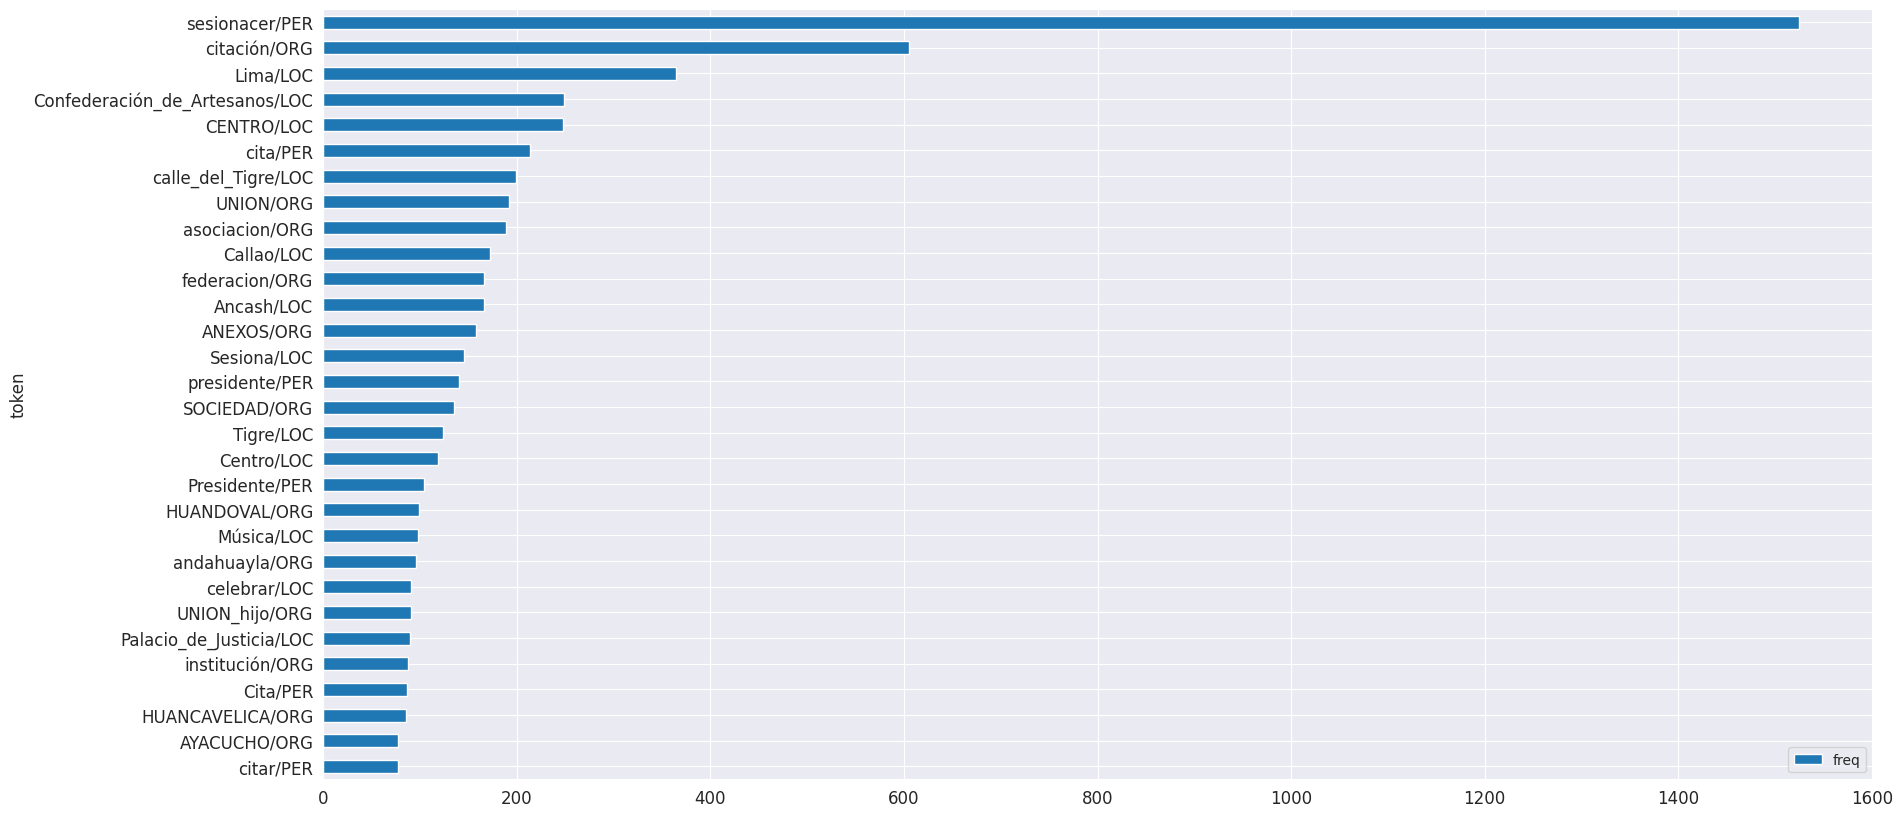

In [70]:
from packages.blueprints.exploration import count_words

count_words(df, 'entities').head(30).plot(kind='barh', figsize=(20,10)).invert_yaxis()

### Almacenar resultado en base de datos

In [71]:
df[nlp_columns] = df[nlp_columns].applymap(lambda items: ' '.join(items))

con = sqlite3.connect(db_name) 
df.to_sql("lima_andina_articulos_nlp", con, index=False, if_exists="replace")
con.close()

6575